In [6]:
from pathlib import Path
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np


In [7]:
# Load the distance matrix or expression matrix first
DATA_PROCESSED = Path("../data/processed")
gse_id = "GSE2034"
dist_matrix = pd.read_parquet(DATA_PROCESSED / f"{gse_id}_distance_matrix.parquet")

# Extract ordered list of gene IDs
gene_ids = dist_matrix.index.tolist()

print(f"Number of genes: {len(gene_ids)}")


Number of genes: 7291


In [13]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

dist_vector = squareform(dist_matrix.values, checks=False)
Z = linkage(dist_vector, method="ward")

k_reference = 10  # Set desired number of clusters
baseline_labels = fcluster(Z, k_reference, criterion="maxclust")
clusters = pd.DataFrame({'gene_id': gene_ids, 'cluster': baseline_labels})


In [15]:
enrichment_results = {}

for k in range(1, k_reference + 1):
    cluster_genes = clusters.loc[clusters['cluster'] == k, 'gene_id'].dropna().unique().tolist()
    if not cluster_genes:
        continue

    enr = gp.enrichr(
        gene_list=cluster_genes,
        gene_sets=['GO_Biological_Process_2021', 'KEGG_2021_Human'],
        organism='Human',
        outdir=f"./enrichr_results/cluster_{k}",
        cutoff=0.05
    )
    enrichment_results[k] = enr.results


2025-11-19 10:24:08,751 [ERROR] Gene set KEGG_2021_Human generated an exception: Warning: No enrich terms when cutoff = 0.05
2025-11-19 10:24:08,786 [ERROR] Gene set GO_Biological_Process_2021 generated an exception: Warning: No enrich terms when cutoff = 0.05



--- Cluster 1: Top Enriched Pathways ---
                        Term  Adjusted P-value  Odds Ratio
0  Oxidative phosphorylation          0.011452    3.608778
1    Diabetic cardiomyopathy          0.011452    2.938786
2         Huntington disease          0.015741    2.427765
3              Thermogenesis          0.083211    2.386510
4              RNA transport          0.204905    2.300831

--- Cluster 2: Top Enriched Pathways ---
                            Term  Adjusted P-value  Odds Ratio
0                     Cell cycle      2.015153e-14    9.145532
1                  RNA transport      1.862213e-08    5.054787
2                DNA replication      9.302348e-08   14.647193
3       Homologous recombination      4.100456e-06   10.721667
4  Amyotrophic lateral sclerosis      4.100456e-06    3.072956

--- Cluster 3: Top Enriched Pathways ---
                                     Term  Adjusted P-value  Odds Ratio
0            Epstein-Barr virus infection      3.481378e-15    8.59404

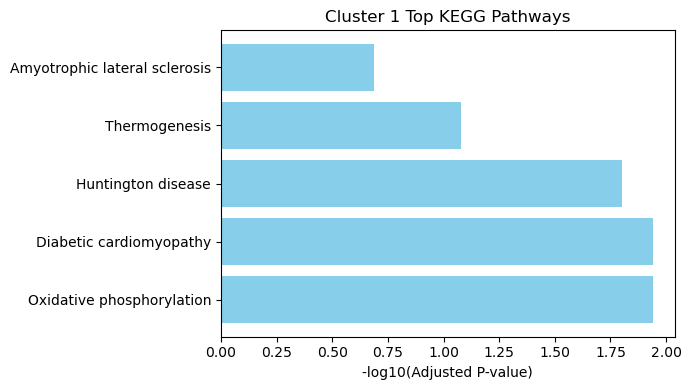

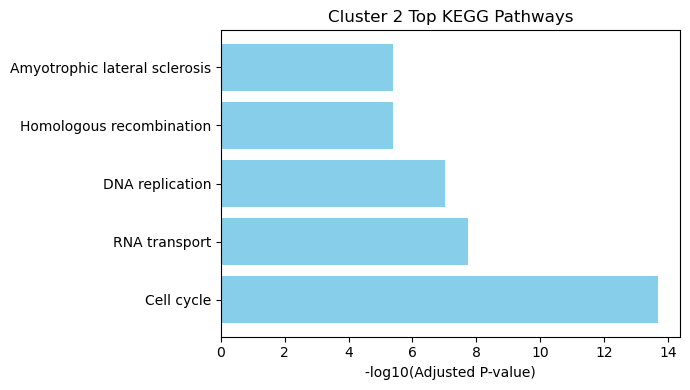

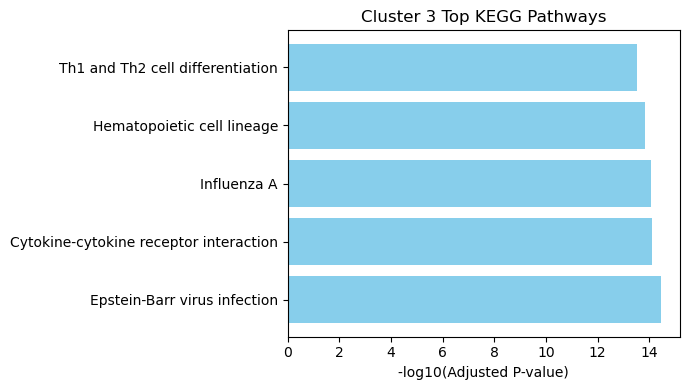

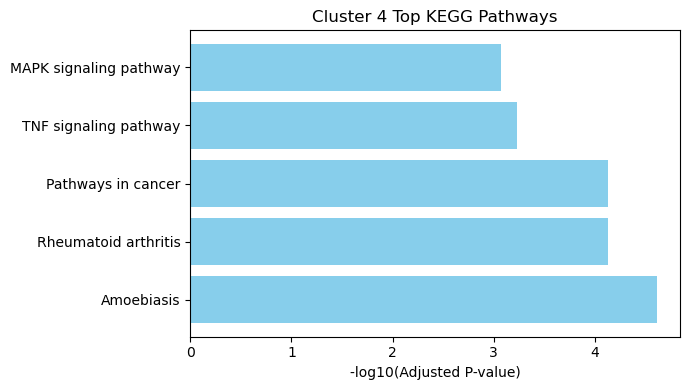

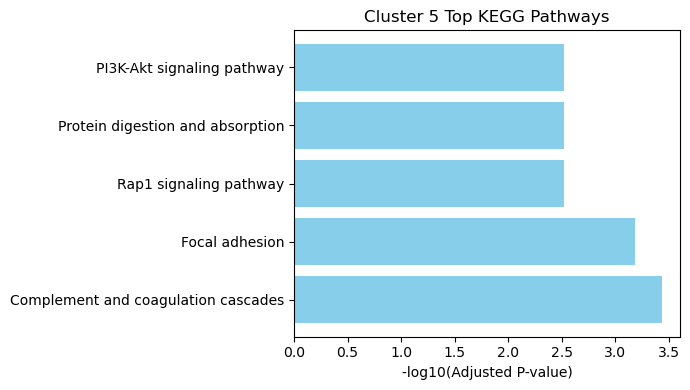

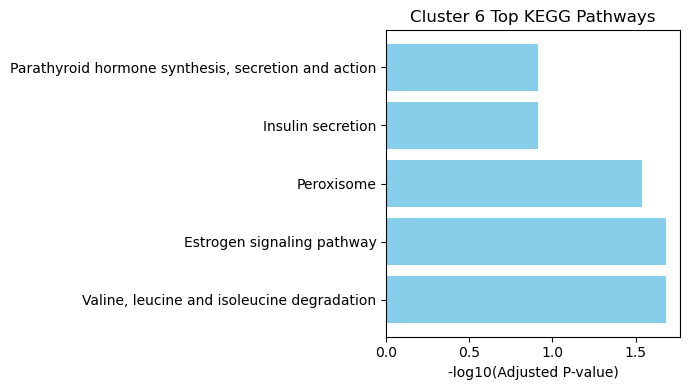

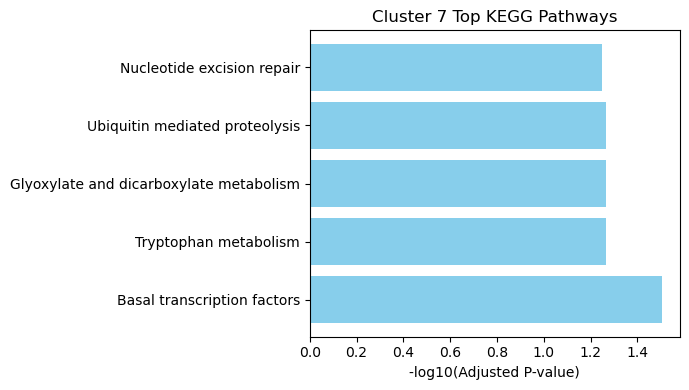

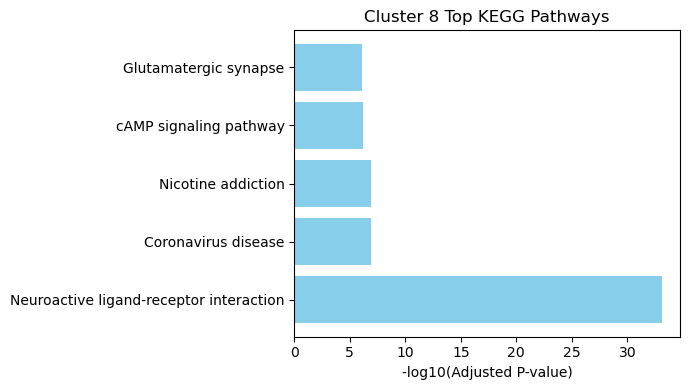

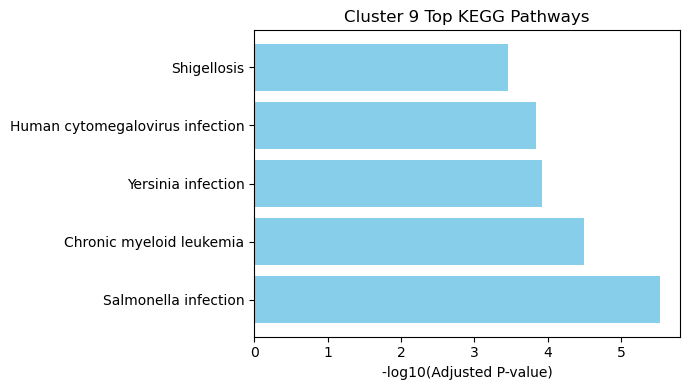

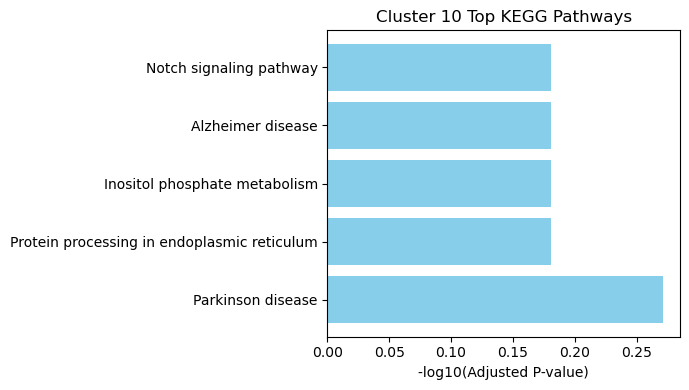

In [16]:
for k, result_df in enrichment_results.items():
    print(f"\n--- Cluster {k}: Top Enriched Pathways ---")
    print(result_df[['Term', 'Adjusted P-value', 'Odds Ratio']].head(5))

for k, result_df in enrichment_results.items():
    top_kegg = result_df[result_df['Gene_set'] == 'KEGG_2021_Human'].sort_values('Adjusted P-value').head(5)
    if not top_kegg.empty:
        plt.figure(figsize=(7, 4))
        plt.barh(top_kegg['Term'], -np.log10(top_kegg['Adjusted P-value']), color='skyblue')
        plt.xlabel('-log10(Adjusted P-value)')
        plt.title(f"Cluster {k} Top KEGG Pathways")
        plt.tight_layout()
        plt.show()
